In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
import numpy as np

df = pd.read_csv("data/NIST_Visc_data.csv")

feats = pd.DataFrame(df, columns=["MolFrac_1", "T"])
data = pd.DataFrame(df, columns=["MOL_1", "MOL_2", "Visc"])


feats.to_csv("data/features1.csv", index=False)
data.to_csv("data/data1.csv", index=False)

df = pd.read_csv("ManyProp/data/data.csv")

data_list = [] 
for idx, row in df.iterrows():
    smi1 = row['MOL_1']
    smi2 = row['MOL_2']
    mol1 = MoleculeModel(smi1, 0.5)()
    mol2 = MoleculeModel(smi2, 0.5)()
    target = row['logV']
    data_list.append((MixtureDataset([mol1, mol2], float(target))))

data_list = [ds.to_tuple() for ds in data_list]

In [2]:
from ManyProp.args import Args
from ManyProp.model.train import run_training
from ManyProp.data.data_pipeline import parse_data

In [ ]:
args = Args()
args().epochs = 30
#args().num_folds = 2
#args().num_layers=2
#args().dropout=0.1
args().data_points=40
#args().data_path="./data/data1.csv"
#args().features_path="./data/features1.csv"
#args().smiles_columns=['MOL_1', 'MOL_2']
#args().targets_column=['logV']
#args().mol_frac_columns=['MolFrac_1']
args().normalize = True
args().log = True

args().loss_function = "SmoothL1"

data = pd.read_csv(args().data_path)
feat_data = pd.read_csv(args().mol_features_path) 

all_data = pd.concat([data, feat_data], axis=1)
all_data.head()

data_list = parse_data(args=args,num_dp=100)

pd.DataFrame(data_list[:10]).head()

from ManyProp.utils import make_splits

train_data, val_data, test_data = make_splits(args=args, data_list=data_list)

dl = make_dl(args=args, data_list=data_list)
train_dl = make_dl(args=args, data_list=train_data)
val_dl = make_dl(args=args, data_list=val_data)
test_dl = make_dl(args=args, data_list=test_data)

In [4]:
import matplotlib.pyplot as plt

In [5]:
losses = run_training(args=args)#, train_dl=train_dl, val_dl=val_dl) 

KeyError: 'Property'

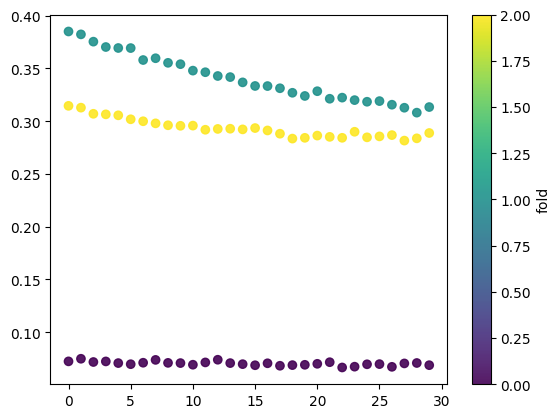

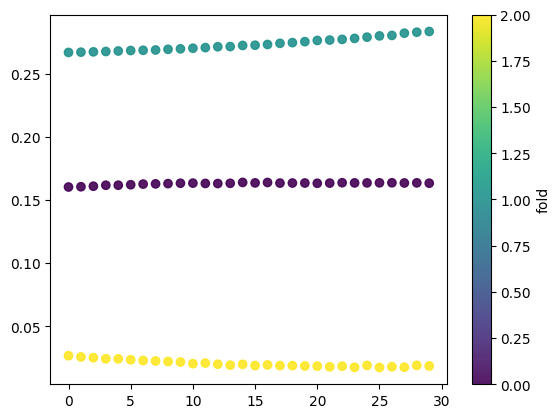

In [ ]:
x = np.array([tup[1] for tup in losses])
y = np.array([tup[2] for tup in losses])

c = np.array([tup[0] for tup in losses])

plt.scatter(x, y, c=c, cmap='viridis', alpha=0.9)
plt.colorbar(label="fold")

plt.show()
y = np.array([tup[3] for tup in losses])
plt.scatter(x, y, c=c, cmap='viridis', alpha=0.9)
plt.colorbar(label="fold")

plt.show()

In [ ]:
def make_plot(idx, losses_arr):
    fold_losses = []

    for n in range(args().num_folds):
        fold_losses.append([])
        for tup in losses_arr:
            if tup[0]==n:
                fold_losses[n].append(tup[idx])

    avg_losses = []
    avg_vars = []
    for e in range(args().epochs):
        losses_arr = []
        
        for f in fold_losses:
            losses_arr.append(f[e])
        avg_losses.append(np.mean(losses_arr).item())
        avg_vars.append(np.var(losses_arr).item())
    x=range(args().epochs)
    a, b = np.polyfit(x, avg_losses, 1)

    plt.errorbar(x=x,y=avg_losses, yerr=avg_vars, fmt='o', capsize=5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(x, a*x+b)
    plt.show()

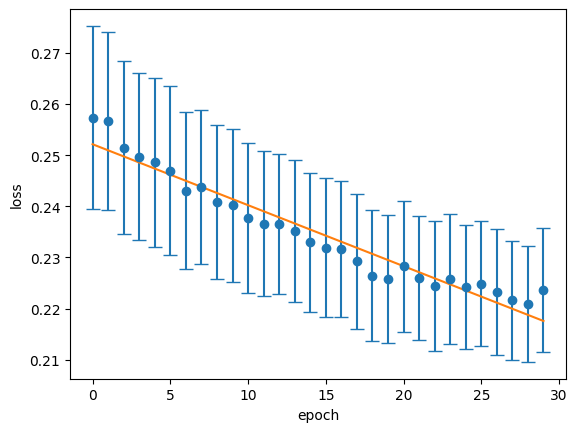

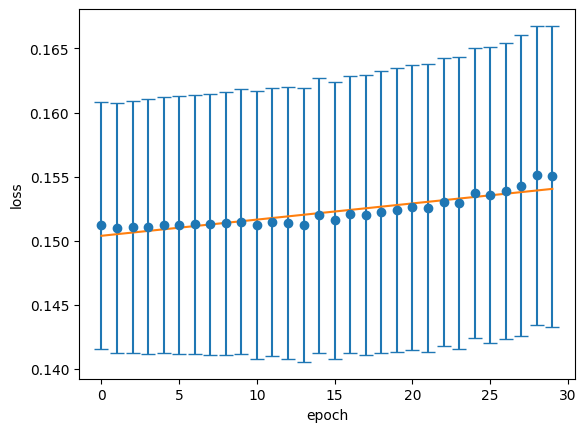

In [ ]:
make_plot(2, losses_arr=losses)
make_plot(3, losses_arr=losses)

In [ ]:
from ManyProp.data.testing import rand_mol


In [ ]:
from ManyProp.model.predict import predict
#["COCCOC","CCCN"]
args().smiles = ["CCCN","COCCOC"]
args().mol_fracs = [0.25, 0.75]
pred, var = predict(args=args)
print(f"prediction: {pred} - var: {var}")

model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
prediction: 0.8278164039651928 - var: 0.0037858773821765547


10**pred

model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:

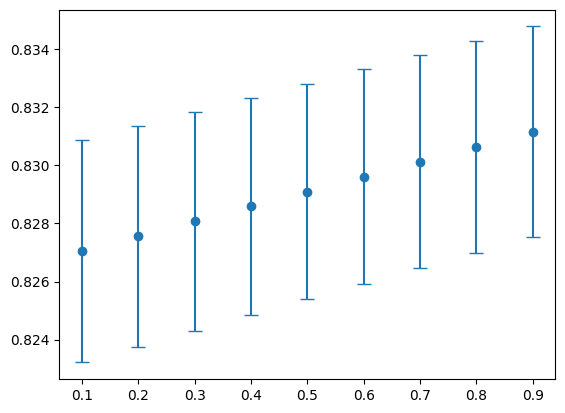

In [ ]:
from ManyProp.model.predict import predict_graph
import matplotlib.pyplot as plt
fracs, predictions, vars = predict_graph(args)

plt.errorbar(x=fracs,y=predictions, yerr=vars, fmt='o', capsize=5)
plt.show()


0.10665317578241229 

0.9376093910024833
1.4904445287051609